# Attention Model Notebook
A quick view of an attentional model for a timeseries problem

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from utils import cyclical_encoder
from utils import train_val_test_split
from utils import get_model_metrics


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from utils import cyclical_encoder
from utils import train_val_test_split
from utils import train_val_test_split_np
from utils import get_model_metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare Data

#### To automate the data loading the following function was written

In [2]:
def load_data(resolution, nan_value, val_days, test_days):
    
    if resolution == '16x10':
        path = '/home/tjarke/Desktop/Residual_Load/work/Feature_channels/'
        file = f'feature_channel_{resolution}.npy'
        feature_channel = np.load(path+file, allow_pickle=False)

        # get rid of all nans - replace them with nan_value
        feature_channel = np.nan_to_num(feature_channel, nan=nan_value)
        
        # rearange the axis to get the examples as the first dimension for the use in tensorflow
        feature_channel = np.moveaxis(feature_channel, -1, 0)
        feature_channel_load = feature_channel[:,:,:,:7]
        print(f'The shape of the feature_channel_load is {feature_channel_load.shape}')
        feature_channel_gen = feature_channel       
        print(f'The shape of the feature_channel_gen is {feature_channel_gen.shape}')
        
    else:
        path = '/home/tjarke/Desktop/Residual_Load/work/Feature_channels/'
        weather_file = f'feature_channel_{resolution}.npy'
        feature_channel_load = np.load(path+weather_file, allow_pickle=False)
        feature_channel_load = np.nan_to_num(feature_channel_load, nan=nan_value)        
        feature_channel_load = np.moveaxis(feature_channel_load, -1, 0)
        print(f'The shape of the feature_channel_load is {feature_channel_load.shape}')
        
        path = '~/Desktop/Residual_Load/work/Feature_channels/'
        ic_file = f'installed_capacities_{resolution}.npy'
        ic_channel = np.load(path+ic_file, allow_pickle=False)
        ic_channel = np.moveaxis(ic_channel, -1, 0)
        feature_channel_gen = np.dstack((feature_channel_load, ic_channel))
        print(f'The shape of the feature_channel_gen is {feature_channel_gen.shape}')

        
    # load the holidays in germany
    path = '/home/tjarke/Desktop/Residual_Load/work/'
    hol_file = 'holidays_encoded.csv'
    df_hol = pd.read_csv(path+hol_file,parse_dates=[0])
    print(f'The df_hol has the shape {df_hol.shape}')
        
    # load the realised values
    path = '~/Desktop/Residual_Load/work/'
    file_realised = 'Day_ahead_dataset.csv'
    df_realised = pd.read_csv(path+file_realised,parse_dates=[1])
    df_realised.drop(columns=["index"],inplace=True)
    # fill all solar nan with zero (even though some times it is during the day)
    df_realised.loc[df_realised['Realised/Solar in MAW'].isnull(),'Realised/Solar in MAW']  = 0
    # fill all other nans with interpolat
    df_realised = df_realised.interpolate(method='linear')
    
#     df_entsoe = df_realised.loc[:,['Day ahead/System total load in MAW', 'Day ahead/Solar in MAW',
#        'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW']].copy()
    
#     df_realised.drop(columns=['index', 'Day ahead/System total load in MAW', 'Day ahead/Solar in MAW',
#        'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)
    # get rid of nans
#     df_realised = df_realised.interpolate(method='linear')
    print(f'The shape of the df_realised is {df_realised.shape}')

    
    target_vars = ["Realised/System total load in MAW",
                   "Realised/Wind Offshore in MAW",
                   "Realised/Wind Onshore in MAW",
                   "Realised/Solar in MAW"]
    
    # Normalize the data
#     X_max = 100_000
#     for col in target_vars:
#         df_realised[col] /= X_max
    
    # create time columns
    
    df_realised['Year'] = df_realised['Date'].dt.year-2014    
    df = cyclical_encoder(df_realised,1440,"minute")
    df = cyclical_encoder(df,12,"month")
    df = cyclical_encoder(df,7,"weekday")

        
    # kill the last 100 rows since these are nan values
    # skip the first year
#     n_start = 0
    n_start = int(96*365*0)
    num_rows = -100
    df = df.iloc[n_start:num_rows,:]
#     df_entsoe = df_entsoe.iloc[:num_rows,:]
    df_hol = df_hol.iloc[n_start:-8,:]
    feature_channel_gen = feature_channel_gen[n_start:num_rows,:,:,:]
    feature_channel_load = feature_channel_load[n_start:num_rows,:,:,:]
    print(f'After getting rid of the last 100 rows and startin after {n_start} steps the shapes are:')
    print(f'df_realised {df.shape}, df_hol {df_hol.shape}, fc_gen {feature_channel_gen.shape}') 
    print(f'fc_load {feature_channel_load.shape}')
    
    # Split the data into train, val, test
    X_train_day, X_train_realised, \
    X_val_day, X_val_realised, \
    X_test_day, X_test_realised = train_val_test_split(df, target_vars, val_days, test_days)
    
    y_true = X_test_realised.copy()
    X_test_realised.drop(columns='Date', inplace=True)
    
    print(f'\nThe order of the columns for X_realised is: {X_train_realised.columns}')
#     print(f'The order of the columns for X_realised is: {X_val_realised.columns}')
#     print(f'The order of the columns for X_realised is: {X_test_realised.columns}\n')
    
    print(f'\nThe order of the columns for X_day is: {X_train_day.columns}')
#     print(f'The order of the columns for X_realised is: {X_val_realised.columns}')
#     print(f'The order of the columns for X_realised is: {X_test_realised.columns}\n')
    
    y_train = X_train_realised.to_numpy(copy=True)
    y_val = X_val_realised.to_numpy(copy=True)
    X_train_day = X_train_day.to_numpy(copy=True)
    X_train_realised = X_train_realised.to_numpy(copy=True)
    X_val_day = X_val_day.to_numpy(copy=True)
    X_val_realised = X_val_realised.to_numpy(copy=True)
    X_test_day = X_test_day.to_numpy(copy=True)
    X_test_realised = X_test_realised.to_numpy(copy=True)
    
    # split the feature channels into train, val, test
    X_train_fc_gen, X_val_fc_gen, X_test_fc_gen = train_val_test_split_np(feature_channel_gen, 
                                                                           val_days, test_days)

    X_train_fc_load, X_val_fc_load, X_test_fc_load = train_val_test_split_np(feature_channel_load, 
                                                                              val_days, test_days)
    
    # pre-process the holidays and split it into train, val and test
    df_hol['holidays'] = df_hol.mean(axis=1)
    df_hol.rename(columns={'time':'Date'},inplace=True)
    cols = [col for col in df_hol.columns if col not in ['holidays']]
#     df_hol['Date'] = 0 # so that the train, val, test split works  
    X_train_hol, _, X_val_hol, _, X_test_hol, _ = train_val_test_split(df_hol, cols, val_days, test_days)
    
    X_train_hol = X_train_hol.to_numpy(copy=True)
    X_val_hol = X_val_hol.to_numpy(copy=True)
    X_testn_hol = X_test_hol.to_numpy(copy=True)
    
    y_test = y_true.iloc[:, :-1].to_numpy(copy=True)
    
    return y_train, y_val, y_true, y_test,\
           X_train_realised, X_val_realised, X_test_realised, \
           X_train_day, X_val_day, X_test_day, \
           X_train_hol, X_val_hol, X_test_hol, \
           X_train_fc_gen, X_val_fc_gen, X_test_fc_gen, \
           X_train_fc_load, X_val_fc_load, X_test_fc_load 

#### Load feature channels, real load and production, and predicted load and production + time encoding

In [3]:
y_train, y_val, y_true, y_test,\
X_train_realised, X_val_realised, X_test_realised, \
X_train_day, X_val_day, X_test_day, \
X_train_hol, X_val_hol, X_test_hol, \
X_train_fc_gen, X_val_fc_gen, X_test_fc_gen, \
X_train_fc_load, X_val_fc_load, X_test_fc_load = load_data('16x10', 0, 90, 90)

The shape of the feature_channel_load is (204096, 16, 10, 7)
The shape of the feature_channel_gen is (204096, 16, 10, 9)
The df_hol has the shape (204004, 17)
The shape of the df_realised is (204096, 9)
After getting rid of the last 100 rows and startin after 0 steps the shapes are:
df_realised (203996, 16), df_hol (203996, 17), fc_gen (203996, 16, 10, 9)
fc_load (203996, 16, 10, 7)
The shape of the data set is: (203996, 16)
--------------------------------------------
The shape of the train set is: (186716, 11)
The shape of the target variable is: (186716, 4)
--------------------------------------------
--------------------------------------------
The shape of the validation set is: (8640, 11)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 11)
The shape of the target variable for the test set is: (8640, 5)
------------------------------

In [4]:
print(f'the y_sets shape: {y_train.shape}, {y_val.shape}, {y_true.shape}')
print(f'the realised sets shape: {X_train_realised.shape}, {X_val_realised.shape}, {X_test_realised.shape}')
print(f'the day set shape: {X_train_day.shape}, {X_val_day.shape}, {X_test_day.shape}')
print(f'the fc_gen shape: {X_train_fc_gen.shape}, {X_val_fc_gen.shape}, {X_test_fc_gen.shape}')
print(f'the fc_load shape: {X_train_fc_load.shape}, {X_val_fc_load.shape}, {X_test_fc_load.shape}')

the y_sets shape: (186716, 4), (8640, 4), (8640, 5)
the realised sets shape: (186716, 4), (8640, 4), (8640, 4)
the day set shape: (186716, 11), (8640, 11), (8640, 11)
the fc_gen shape: (186716, 16, 10, 9), (8640, 16, 10, 9), (8640, 16, 10, 9)
the fc_load shape: (186716, 16, 10, 7), (8640, 16, 10, 7), (8640, 16, 10, 7)


#### Scale the data

In [5]:
day_scaler = StandardScaler()
X_train_day[:,:4] = day_scaler.fit_transform(X_train_day[:,:4])
X_val_day[:,:4] = day_scaler.transform(X_val_day[:,:4])
X_test_day[:,:4] = day_scaler.transform(X_test_day[:,:4])

realised_scaler = StandardScaler()
X_train_realised = realised_scaler.fit_transform(X_train_realised)
X_val_realised = realised_scaler.transform(X_val_realised)
X_test_realised = realised_scaler.transform(X_test_realised)

#y_true is with date, y_test without date
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train)
y_val = target_scaler.transform(y_val)
y_test = target_scaler.transform(y_test)

#### Create a function to make sequences, so that all inputs match up

In [6]:
# create a better generator function:

def generator(recognizer, 
              time_steps_weather, time_steps_realised, time_steps_days,
              feature_matrix_fc_gen, feature_matrix_fc_load, 
              feature_matrix_day, feature_matrix_hol,
              feature_matrix_realised, target_matrix):
    '''
    INPUT:
    recognizer: A string: either 'train', 'val' or 'test'. Make sure each variable gets a unique name
    time_steps_weather: A list: list of time steps to look in the past for the weather data/feature_channel, 
    e.g. 4 means get the value from one hour ago
    time_steps_realised: same as before, but for the realised/actual values
    feature_matrix_fc: numpy array with the information for the feature_channel/weather data
    feature_matrix_lag: same as before, but for the realised/actual data
    target_matrix: numpy array witht the target data
    '''
    max_steps_weather = max(time_steps_weather)
    max_steps_realised = max(time_steps_realised)
    max_steps_days = max(time_steps_days)
    
    # create dictionaries of lists for the features and a list for the target:
    steps_weather_gen_dict = dict()
    steps_weather_load_dict = dict()
    steps_realised_dict = dict()
    steps_days_dict = dict()
    steps_y_target_dict = dict()
   

    
    # concatenate feature_matrix_realised and feature_matrix_day and hol so that the lags have the time info
    # as well
#     feature_matrix_realised = np.concatenate((feature_matrix_realised,
#                                               feature_matrix_day,
#                                               feature_matrix_hol), axis=1)
#     print(f'feature_matrix_realised shape after concat is {feature_matrix_realised.shape}')
    
    # concatenate feature_matrix_day and feature_matrix_hol 
    days_matrix = np.concatenate((feature_matrix_day, feature_matrix_hol), axis=1)
    
    for step in time_steps_weather:
        steps_weather_gen_dict[f'{recognizer}_weather_gen_step_{step}'] = list()

    for step in time_steps_weather:
        steps_weather_load_dict[f'{recognizer}_weather_load_step_{step}'] = list()
        
    for step in time_steps_realised:
        steps_realised_dict[f'{recognizer}_realised_step_{step}'] = list()
    
    for step in time_steps_days:
        steps_days_dict [f'{recognizer}_days_step_{step}'] = list()
        
    for step in time_steps_days:
        steps_y_target_dict[f'{recognizer}_y_target_step_{step}'] = list()
        
        
    # iterate through each element of feature_matrix_fc_gen
    for i in range(len(target_matrix)):
        end_ix = i + max(max_steps_weather, max_steps_realised, max_steps_days)
        # check if we are beyond the dataset
        if end_ix+1 > len(target_matrix):
            break
        for step in time_steps_weather:
            steps_weather_gen_dict[f'{recognizer}_weather_gen_step_{step}'].append(feature_matrix_fc_gen[end_ix - step])

    # iterate through each element of feature_matrix_fc_load
    for i in range(len(target_matrix)):
        end_ix = i + max(max_steps_weather, max_steps_realised, max_steps_days)
        # check if we are beyond the dataset
        if end_ix+1 > len(target_matrix):
            break
        for step in time_steps_weather:
            steps_weather_load_dict[f'{recognizer}_weather_load_step_{step}'].append(feature_matrix_fc_load[end_ix - step])
    
    # iterate through each element of feature_matrix_realised
    for i in range(len(target_matrix)):
        end_ix = i + max(max_steps_weather, max_steps_realised, max_steps_days)
        # check if we are beyond the dataset
        if end_ix+1 > len(target_matrix):
            break
        for step in time_steps_realised:
            steps_realised_dict[f'{recognizer}_realised_step_{step}'].append(feature_matrix_realised[end_ix - step])
            
    for i in range(len(target_matrix)):
        end_ix = i + max(max_steps_weather, max_steps_realised, max_steps_days)
        # check if we are beyond the dataset
        if end_ix+1 > len(target_matrix):
            break
        for step in time_steps_days:
            steps_days_dict[f'{recognizer}_days_step_{step}'].append(days_matrix[end_ix - step])
            steps_y_target_dict[f'{recognizer}_y_target_step_{step}'].append(target_matrix[end_ix - step])
            
#         seq_y_target = target_matrix[end_ix]
#         seq_day = days_matrix[end_ix]
#         y_target.append(seq_y_target)
#         days.append(seq_day)
        
    # transform the lists in the dictionaries to numpy arrays     
    for key in steps_weather_gen_dict.keys():
        steps_weather_gen_dict[key] = np.array(steps_weather_gen_dict[key])
        
    for key in steps_weather_load_dict.keys():
        steps_weather_load_dict[key] = np.array(steps_weather_load_dict[key])
        
    for key in steps_realised_dict.keys():
        steps_realised_dict[key] = np.array(steps_realised_dict[key])
        
    for key in steps_days_dict.keys():
        steps_days_dict[key] = np.array(steps_days_dict[key])

    for key in steps_y_target_dict.keys():
        steps_y_target_dict[key] = np.array(steps_y_target_dict[key])

        

    return steps_weather_gen_dict, steps_weather_load_dict, steps_realised_dict, steps_days_dict, steps_y_target_dict

In [7]:
time_steps_weather = [0]
time_steps_realised = np.arange(1,5,1).tolist()
time_steps_days = np.arange(1,97,1).tolist()

X_train_fc_gen, X_train_fc_load, X_train_realised, X_train_days, y_train = generator('train', 
                                                                                     time_steps_weather, 
                                                                                     time_steps_realised,
                                                                                     time_steps_days,
                                                                                     X_train_fc_gen, 
                                                                                     X_train_fc_load,
                                                                                     X_train_day,
                                                                                     X_train_hol,
                                                                                     X_train_realised,
                                                                                     y_train)


X_val_fc_gen, X_val_fc_load, X_val_realised, X_val_days, y_val = generator('val', 
                                                                             time_steps_weather, 
                                                                             time_steps_realised,
                                                                             time_steps_days, 
                                                                             X_val_fc_gen, 
                                                                             X_val_fc_load,
                                                                             X_val_day,
                                                                             X_val_hol,
                                                                             X_val_realised,
                                                                             y_val)


X_test_fc_gen, X_test_fc_load, X_test_realised, X_test_days, y_test = generator('test', 
                                                                                 time_steps_weather, 
                                                                                 time_steps_realised,
                                                                                 time_steps_days, 
                                                                                 X_test_fc_gen, 
                                                                                 X_test_fc_load,
                                                                                 X_test_day,
                                                                                 X_test_hol,
                                                                                 X_test_realised,
                                                                                 y_test)

In [8]:
# print(X_test_days.shape, y_test.shape)

#### Transform to a numpy tensor

In [8]:
# realised data has to be a one big matrix
X_train_realised = np.stack([var[1] for var in X_train_realised.items()])
X_train_realised = np.moveaxis(X_train_realised, 0, 1)

X_val_realised = np.stack([var[1] for var in X_val_realised.items()])
X_val_realised = np.moveaxis(X_val_realised, 0, 1)

X_test_realised = np.stack([var[1] for var in X_test_realised.items()])
X_test_realised = np.moveaxis(X_test_realised, 0, 1)

print(X_train_realised.shape, X_val_realised.shape, X_test_realised.shape)

(186620, 4, 4) (8544, 4, 4) (8544, 4, 4)


In [9]:
# days data has to be a one big matrix
X_train_days = np.stack([var[1] for var in X_train_days.items()])
X_train_days = np.moveaxis(X_train_days, 0, 1)

X_val_days = np.stack([var[1] for var in X_val_days.items()])
X_val_days = np.moveaxis(X_val_days, 0, 1)

X_test_days = np.stack([var[1] for var in X_test_days.items()])
X_test_days = np.moveaxis(X_test_days, 0, 1)

print(X_train_days.shape, X_val_days.shape, X_test_days.shape)

(186620, 96, 12) (8544, 96, 12) (8544, 96, 12)


In [10]:
# y data has to be a one big matrix
y_train = np.stack([var[1] for var in y_train.items()])
y_train = np.moveaxis(y_train, 0, 1)

y_val = np.stack([var[1] for var in y_val.items()])
y_val = np.moveaxis(y_val, 0, 1)

y_test = np.stack([var[1] for var in y_test.items()])
y_test = np.moveaxis(y_test, 0, 1)

print(y_train.shape, y_val.shape, y_test.shape)

(186620, 96, 4) (8544, 96, 4) (8544, 96, 4)


In [11]:
# transform each key/value of the feature_channel/weather to a global variable
for key,val in X_train_fc_gen.items():
    exec(key + '=val')
        
for key,val in X_val_fc_gen.items():
    exec(key + '=val')

for key,val in X_test_fc_gen.items():
    exec(key + '=val')
    

for key,val in X_train_fc_load.items():
    exec(key + '=val')
        
for key,val in X_val_fc_load.items():
    exec(key + '=val')

for key,val in X_test_fc_load.items():
    exec(key + '=val')

# The Model
## Model input variables

In [12]:
conv_part_train = train_weather_gen_step_0.astype('float32')
conv_part_val = val_weather_gen_step_0.astype('float32')
conv_part_test = test_weather_gen_step_0.astype('float32')

attn_part_train = X_train_realised.astype('float32')
attn_part_val = X_val_realised.astype('float32')
attn_part_test = X_test_realised.astype('float32')

tabular_part_train = X_train_days.astype('float32')
tabular_part_val = X_val_days.astype('float32')
tabular_part_test = X_test_days.astype('float32')

target_train = y_train.reshape(-1,96*4).astype('float32')
target_val = y_val.reshape(-1,96*4).astype('float32')
# target_test = y_test.astype('float32')


n_steps_conv = len(time_steps_weather)

n_steps = X_train_realised.shape[1]
n_features = X_train_realised.shape[2]

n_tab_in_steps = X_train_days.shape[1]
n_tab_in_features = X_train_days.shape[2]

In [13]:
X_train_days.shape

(186620, 96, 12)

## Convolution Pillar

#### Create a function for the complete convolutional layer

This would allow us to create multiple layers in case we want to add multiple weather timesteps

In [15]:
# set the convolution steps

def conv_layers(conv_dict, number, input_shape, filter_1, window_size_1, filter_2, window_size_2,
                filter_3, window_size_3):
    conv_input_dict[f'Conv_input_{number}'] = Input(shape=input_shape)
    
    Conv2D = tf.keras.layers.Conv2D(filters=filter_1, 
                       kernel_size=window_size_1,
#                        padding='same',
                       activation='relu')(conv_input_dict[f'Conv_input_{number}'])
#     Normalization = tf.keras.layers.BatchNormalization()(Conv2D, training=True)
    MaxPool = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1))(Conv2D)
#     dropout = tf.keras.layers.Dropout(0.25, seed=42)(MaxPool, training=True)
#     MaxPool = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1))(Conv2D)
#     dropout = tf.keras.layers.Dropout(0.25)(MaxPool)
    
    Conv2D = tf.keras.layers.Conv2D(filters=filter_2, 
                       kernel_size=window_size_2,
                       activation='relu')(MaxPool)
#     Normalization = tf.keras.layers.BatchNormalization()(Conv2D, training=True)
    MaxPool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1))(Conv2D)
#     dropout = tf.keras.layers.Dropout(0.25, seed=42)(MaxPool, training=True)
#     MaxPool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1))(Conv2D)
#     dropout = tf.keras.layers.Dropout(0.25)(MaxPool)
#     Conv2D = tf.keras.layers.Conv2D(filters=filter_3, 
#                        kernel_size=window_size_3,
#                        activation='relu')(dropout)
#     Normalization = tf.keras.layers.BatchNormalization()(Conv2D, training=True)
#     MaxPool = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1))(Normalization)  
#     dropout = tf.keras.layers.Dropout(0.25, seed=42)(MaxPool, training=True)

#     dense = tf.keras.layers.Dense(32, activation='relu')(dropout)
#     dense = tf.keras.layers.Dense(16, activation='relu')(dense)
#     dense = tf.keras.layers.Dense(4, activation='relu')(dense)
    
#     flatten = tf.keras.layers.Flatten()(dense)
    flatten = tf.keras.layers.Flatten()(MaxPool)
#     dense = tf.keras.layers.Dense(64, activation='relu')(flatten)
#     dense = tf.keras.layers.Dense(16, activation='relu')(flatten)
#     return dense
    return flatten

In [16]:
# Convolution part

# since there is no lag, the attention layer and the for loop are unecessary
n_steps_conv = len(time_steps_weather)
conv_input_dict = dict()

output_conv = conv_layers(conv_input_dict, 0, (16,10,9), 64, (3,3), 64, (3,3), 8, (3,3))

convolution_in = conv_input_dict["Conv_input_0"]
# mdl = Model(inputs=conv_input_dict["Conv_input_0"], outputs=flatten)
# mdl.summary()

## Attention Pillar


#### Define a function for positional encoding (copy paste from tensorflow tutorial):

In [14]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Create a function for an attention head:

In [18]:
def attention_head(attn_in, capacity):
    Q = Dense(capacity, activation='linear')(attn_in)
    K = Dense(capacity, activation='linear')(attn_in)
    V = Dense(capacity, activation='linear')(attn_in)
    query_value_attention  = tf.keras.layers.Attention(use_scale=True)([Q,V,K])
    return tf.reduce_sum(query_value_attention, 1)  

### Create Attention pillar

In [19]:
attention_in = Input(shape=(n_steps, n_features))

d_model = n_features
position = n_steps
pos_attention = tf.math.add(attention_in,positional_encoding(position,d_model))

capacity = n_features
n_heads = n_steps
list_heads = []
for i in range(n_heads):
    list_heads.append(attention_head(pos_attention, capacity))
    
# heads_out = tf.keras.backend.stack(list_heads,axis=1)
# dense_heads = tf.keras.layers.Dense(n_features, activation='relu')(heads_out)
# add_with_skip = tf.math.add(dense_heads,attention_in)
# layer_norm = tf.keras.layers.LayerNormalization()(add_with_skip)

input_into_NN = tf.keras.layers.Concatenate()(list_heads)
ouput_attn = tf.keras.layers.Flatten()(input_into_NN)
# prediction = Dense(4,activation='linear')(flatten)

# mdl = Model(inputs=[attention_in], outputs=[prediction])
# mdl.summary()

#### Tabular pillar

In [20]:
tabular_in = Input(shape=(n_tab_in_steps,n_tab_in_features))

# output_tab = tf.keras.layers.Dense(n_tab_in_features, activation='relu')(tabular_in)
dense_tab = tf.keras.layers.Dense(n_tab_in_features, activation='relu')(tabular_in)
output_tab = tf.keras.layers.Flatten()(dense_tab)


# mdl = Model(inputs=tabular_in, outputs=output_tab)
# mdl.summary()

#### Combine the pillars

In [21]:
# combine_in = tf.keras.layers.Concatenate(axis=1)([output_conv, output_attn, output_tab])

# dense_combine = tf.keras.layers.Dense(16, activation='relu')(combine_in)
# ouput = tf.keras.layers.Dense(4, activation='relu')(dense_combine)

# mdl = Model(inputs=[convolution_in, attention_in, tabular_in], outputs=ouput)
# mdl.summary()

combine_in = tf.keras.layers.Concatenate(axis=1)([output_conv, ouput_attn, output_tab])

dense_combine = tf.keras.layers.Dense(4*96*3, activation='relu')(combine_in)
# dropout = tf.keras.layers.Dropout(0.3, seed=42)(dense_combine)
dense_combine = tf.keras.layers.Dense(4*96*2, activation='relu')(dense_combine)
# dropout = tf.keras.layers.Dropout(0.1, seed=42)(dense_combine)
ouput = tf.keras.layers.Dense(4*96, activation='linear')(dense_combine)
# output = tf.reshape(ouput,(None,n_tab_in_steps,4))

mdl = Model(inputs=[convolution_in, attention_in,tabular_in], outputs=ouput)
mdl.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 4)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 16, 10, 9)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_Add (TensorFlowOpLa [(None, 4, 4)]       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 8, 64)    5248        input_1[0][0]                    
_______________________________________________________________________________________

### Compile and train it

(Or load the pretrained model)

In [17]:
mdl = tf.keras.models.load_model('models/hydra_v3_96_MASE_two')
# 

loss_function = tf.keras.losses.Huber(delta=1.0)
                                
mdl.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = loss_function,
    metrics = ["mean_absolute_error"]
)
# import tensorflow_addons as tfa
# learning_rate_schedule = tfa.optimizers.ExponentialCyclicalLearningRate(
#                             initial_learning_rate = 0.0001,
#                             maximal_learning_rate =  0.01,
#                             step_size = 0.0001,
#                             scale_mode = 'iterations',
#                             gamma = 1.0,
#                             name = 'ExponentialCyclicalLearningRate'
#                         )
# mdl.compile(loss='mean_squared_error',
#             optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule),
#             metrics=['mean_absolute_error'])

In [18]:
# history = mdl.fit(
#     [conv_part_train, attn_part_train, tabular_part_train],target_train,
#     epochs=5,
#     batch_size=32,
#     validation_data=([conv_part_val, attn_part_val, tabular_part_val],target_val),
#     shuffle=False)

In [19]:
# history.history
# plt.plot(history.history["loss"],label = "loss")
# plt.plot(history.history["val_loss"],label = "val_loss")
# plt.legend()
# plt.show()
# plt.close()


# history.history
# plt.plot(history.history["mean_absolute_error"],label = "MAE")
# plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
# plt.legend()
# plt.show()
# plt.close()

## 

## Evaluation

Safe the model for future use:

In [41]:
# mdl.save('models/hydra_v3_96_safety_save')

#### Define error function

In [20]:
def MAE_MASE(y_true,y_pred):
    overall_mae = mean_absolute_error(y_true, y_pred)
    
    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive
    
    return overall_mae, overall_mase

#### Calculate train and test error

In [21]:
# y_pred = y_test
y_pred = mdl.predict([conv_part_test, attn_part_test, tabular_part_test])
y_pred = y_pred.reshape(-1,n_tab_in_steps,4)
y_pred_back = target_scaler.inverse_transform(y_pred)
y_test_back = target_scaler.inverse_transform(y_test)


list_names = ["Load","Wind Offshore", "Wind Onshore", "Solar"]

for i in range(len(list_names)):
    print("=================================")
    print(f"{list_names[i]}")
    overall_mae, overall_mase = MAE_MASE(y_test_back[:,i],y_pred_back[:,i])
    print(f"The overall mean absolute error of the model in MW is: {overall_mae}")
    print(f"The overall mean absolute error of the model in MW is: {overall_mase}")
    print("=================================")
    
print("VALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVAL")    
# y_pred = y_test
y_pred_val = mdl.predict([conv_part_val, attn_part_val, tabular_part_val])
y_pred_val = y_pred_val.reshape(-1,n_tab_in_steps,4)
y_pred_back_val = target_scaler.inverse_transform(y_pred_val)
y_val_back = target_scaler.inverse_transform(y_val)


list_names = ["Load","Wind Offshore", "Wind Onshore", "Solar"]

for i in range(len(list_names)):
    print("=================================")
    print(f"{list_names[i]}")
    overall_mae, overall_mase = MAE_MASE(y_val_back[:,i],y_pred_back_val[:,i])
    print(f"The overall mean absolute error of the model in MW is: {overall_mae}")
    print(f"The overall mean absolute error of the model in MW is: {overall_mase}")
    print("=================================")

Load
The overall mean absolute error of the model in MW is: 744.2831243637787
The overall mean absolute error of the model in MW is: 2.4367497516677368
Wind Offshore
The overall mean absolute error of the model in MW is: 660.6418698372248
The overall mean absolute error of the model in MW is: 2.162841686722558
Wind Onshore
The overall mean absolute error of the model in MW is: 588.212480570691
The overall mean absolute error of the model in MW is: 1.9256283991240406
Solar
The overall mean absolute error of the model in MW is: 535.9866295468535
The overall mean absolute error of the model in MW is: 1.754658256597804
VALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVALVAL
Load
The overall mean absolute error of the model in MW is: 843.3074409844432
The overall mean absolute error of the model in MW is: 2.7391883618258692
Wind Offshore
The overall mean absolute error of the model in MW is: 756.1538820756128
The overall mean absolute error of the mo

#### Compare the actual day to day forecast with Entsoe

Look at the dates in the test set to determine the starting index

In [43]:
y_true.head(n=6) #23:00 = 4th row

,Realised/System total load in MAW,Realised/Wind Offshore in MAW,Realised/Wind Onshore in MAW,Realised/Solar in MAW,Date
195356,44479.0,5000.0,16170.0,0.0,2020-07-27 22:00:00
195357,43853.0,5221.0,16486.0,0.0,2020-07-27 22:15:00
195358,43512.0,5308.0,16353.0,0.0,2020-07-27 22:30:00
195359,42879.0,5225.0,16530.0,0.0,2020-07-27 22:45:00
195360,42380.0,5031.0,16620.0,0.0,2020-07-27 23:00:00
195361,41921.0,5129.0,16725.0,0.0,2020-07-27 23:15:00


In [44]:
complete_days_pred = y_pred_back[4::96,:,:]
complete_days_test = y_test_back[4::96,:,:]

for i in range(len(list_names)):
    print("=================================")
    print(f"{list_names[i]}")
    overall_mae, overall_mase = MAE_MASE(complete_days_test[:,i],complete_days_pred[:,i])
    print(f"The overall mean absolute error of the model in MW is: {overall_mae}")
    print(f"The overall mean absolute error of the model in MW is: {overall_mase}")
    print("=================================")


    
print("ENTSOEENTSOENTSOENTSOENTSOENTSOENTSOENTSOENTSOENTSO")
    
complete_days_entso = tabular_part_test[4::96,:,0:4]
complete_days_entso = target_scaler.inverse_transform(complete_days_entso)

for i in range(len(list_names)):
    print("=================================")
    print(f"{list_names[i]}")
    overall_mae, overall_mase = MAE_MASE(complete_days_test[:,i],complete_days_entso[:,i])
    print(f"The overall mean absolute error of the model in MW is: {overall_mae}")

    print(f"The overall mean absolute error of the model in MW is: {overall_mase}")
    print("=================================")

Load
The overall mean absolute error of the model in MW is: 609.6617704254858
The overall mean absolute error of the model in MW is: 0.25689518895586383
Wind Offshore
The overall mean absolute error of the model in MW is: 562.4866724087951
The overall mean absolute error of the model in MW is: 0.2351804901741128
Wind Onshore
The overall mean absolute error of the model in MW is: 514.3811626010731
The overall mean absolute error of the model in MW is: 0.2157608049786356
Solar
The overall mean absolute error of the model in MW is: 472.84885416556614
The overall mean absolute error of the model in MW is: 0.1984565000862173
ENTSOEENTSOENTSOENTSOENTSOENTSOENTSOENTSOENTSOENTSO
Load
The overall mean absolute error of the model in MW is: 3215.031942839033
The overall mean absolute error of the model in MW is: 1.3345410749624083
Wind Offshore
The overall mean absolute error of the model in MW is: 3227.908556865842
The overall mean absolute error of the model in MW is: 1.3374337156815144
Wind On

## Create plots 

In [45]:
import datetime
import plotly.express as px

(-3000.0, 3000.0)

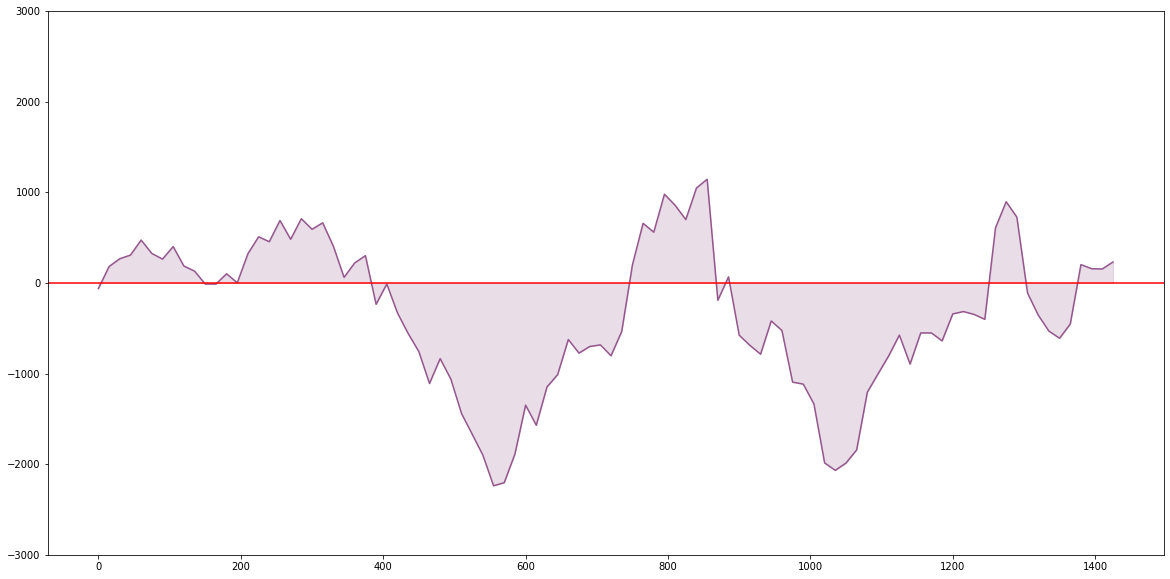

In [46]:
# load the dataset Day-ahead-dataset
# import Entso-E data
# path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file = 'Day_ahead_dataset.csv'
df_rl = pd.read_csv(file)
df_rl.drop(columns='index', inplace=True)
df_rl.Date = pd.to_datetime(df_rl.Date, format='%Y-%m-%d %H:%M:%S')

# create a day column
df_rl['day'] = df_rl.Date.dt.date
df_rl['year'] = df_rl.Date.dt.year

# create the relevant columns
df_rl['realised_res_load'] = df_rl.iloc[:, 7] - df_rl.iloc[:, [2,6,8]].sum(axis=1) 
df_rl['entsoe_res_load'] = df_rl.iloc[:, 1] - df_rl.iloc[:, [3,4,5]].sum(axis=1)
df_rl['diff_entsoe'] = df_rl['realised_res_load'] - df_rl['entsoe_res_load']
df_rl['minute'] = (df_rl['Date'].dt.hour*60 + df_rl['Date'].dt.minute)
mask = (df_rl.day == datetime.date(2020,7,19))
zero_plot = df_rl.loc[mask,['minute', 'diff_entsoe']]
# zero_plot = df_rl.query('day == "2020-07-19"')[['minute', 'diff_entsoe']]


# create the graphic
color = 'xkcd:purplish'
plt.figure(figsize=(20,10))
plt.plot(zero_plot.minute, zero_plot.diff_entsoe, color=color)
plt.axhline(0, color='r')
plt.fill_between(zero_plot.minute, zero_plot.diff_entsoe, 0, alpha=0.2, color=color)
plt.ylim((-3000, 3000))

In [47]:
df_results_a = pd.DataFrame(complete_days_test.reshape(-1,4),columns=['aL','aWOff','aWOn','asolar'])
df_results_e = pd.DataFrame(complete_days_entso.reshape(-1,4),columns=['eL','eWOff','eWOn','esolar'])
df_results_p = pd.DataFrame(complete_days_pred.reshape(-1,4),columns=['pL','pWOff','pWOn','psolar'])

In [27]:
df_results = pd.concat([df_results_a, df_results_e, df_results_p],axis=1)

In [48]:
df_results['Actual Value'] = df_results_a.aL - (df_results_a.aWOff+df_results_a.aWOn+df_results_a.asolar)
df_results['Transparency platform'] = df_results_e.eL - (df_results_e.eWOff+df_results_e.eWOn+df_results_e.esolar)
df_results['Our model'] = df_results_p.pL - (df_results_p.pWOff+df_results_p.pWOn+df_results_p.psolar)
df_results['Date'] = y_true.iloc[4:-92,-1].reset_index(drop=True)

In [49]:
d=30
fig = px.line(df_results.loc[96*d:96*(d+3)-1:],x='Date',y=['Actual Value','Transparency platform','Our model'],
       width=1000)
fig.update_yaxes(title="Residual load MW",range=[-3000, 60000])
fig.show()

In [50]:
# fig.write_image("Presentation_stuff/actual_residual_all.png")

In [51]:
df_results['Error Transparency platform'] = np.abs(df_results.loc[:,'Actual Value']-df_results.loc[:,'Transparency platform'])
df_results['Error Our model'] = np.abs(df_results.loc[:,'Actual Value']-df_results.loc[:,'Our model'])
df_results['Perfect prediction'] = np.zeros((df_results.shape[0],1))

In [52]:
fig = px.line(df_results.loc[96*d:96*(d+3)-1:],x='Date',y=['Perfect prediction','Error Transparency platform','Error Our model'],
       width=1000,)


# fig = px.line(df_results.loc[96*d:96*(d+3)-1:],x='Date',y=['Error Transparency platform', line_color='#ffe476',
#        width=1000)

fig.update_yaxes(title="Absolute error in Residual load MW")#,range=[-3000, 60000])
fig.show()

In [21]:
# train_size = df_rl.shape[0]-180*96
# summerday_index = 194500

In [53]:
# index_total = train_size +90*96*2
# in_val_set = summerday_index - train_size 
# in_val_set